In [1]:
import xtrack as xt
import xobjects as xo
import xcoll as xc
import xpart as xp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

In [2]:
line = xt.Line.from_json('../injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

#Set cavitiy voltages correctly
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180

line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180

#Add displacment of vertical dogleg in LSS5
line['qd.51710'].shift_y = -5.273e-3
line['qfa.51810'].shift_y = -17.369e-3
line['qd.51910'].shift_y = -5.273e-3

tab = line.get_table()
mask = [el.startswith('Limit') for el in tab.element_type]

for name in tab.name[mask]:
    if 'qd.51710' in name:
        line[name].shift_y = -5.273e-3
    elif 'qfa.51810' in name:
        line[name].shift_y = -17.369e-3
    elif 'qd.51910' in name:
        line[name].shift_y = -5.273e-3
tw = line.twiss()

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
num_turns = 1000
num_particles = 100

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [4]:
#Check aperture
df_with_coll = line.check_aperture()

#OPtimize line and optics
line.build_tracker()
tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
# line.optimize_for_tracking()

Checking aperture:   0%|          | 0/30210 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
The line already has an associated tracker


In [5]:
#x and y on closed orbit
part = line.build_particles(
    x_norm = np.zeros(num_particles),
    y_norm = np.zeros(num_particles),
    px_norm = np.zeros(num_particles),
    py_norm = np.zeros(num_particles),
    zeta= np.zeros(num_particles),
    delta = np.linspace(-5e-4, 5e-4, num_particles),
    nemitt_x=3.5e-6, nemitt_y=3.5e-6
)
N_part = num_particles
# part = xt.Particles(
#     x = np.ones(N_part) * tw.particle_on_co.x[0], #np.linspace(-40e-3, 40e-3, N_part),
#     px = np.ones(N_part) * tw.particle_on_co.px[0],
#     y = np.ones(N_part) * tw.particle_on_co.y[0],
#     py = np.ones(N_part) * tw.particle_on_co.py[0],
#     delta = np.linspace(-5e-3, 5e-3, N_part), #np.ones(N_part) * tw.particle_on_co.delta[0],
#     zeta = np.ones(N_part) * tw.particle_on_co.zeta[0],
#     p0c = np.ones(N_part) * tw.particle_on_co.p0c[0],
# )
part2 = part.copy()
#variations for close to bottleneck
# x_sigma = 12
# y_sigma = 5.5
# angle = 0 #np.pi/4, np.pi/2, np.pi*3/4, np.pi, np.pi*5/4, np.pi*3/2, np.pi*7/4

# part = xt.Particles(
#     x_norm = np.ones(num_particles)*x_sigma*np.cos(angle),
#     y_norm = np.ones(num_particles)*y_sigma*np.cos(angle),
#     px_norm = np.ones(num_particles)*x_sigma*np.sin(angle),
#     py_norm = np.ones(num_particles)*y_sigma*np.sin(angle),
#     zeta= np.zeros(num_particles),
#     delta = np.linspace(-5e-3, 5e-3, num_particles),
# )

In [6]:
tw = line.twiss()

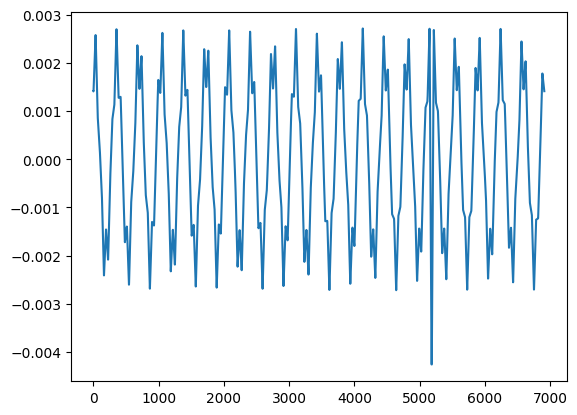

In [7]:
plt.figure()
plt.plot(tw.s, tw.y)

In [8]:
monitor = xt.ParticlesMonitor(_context=line._context,
    num_particles=num_particles,
    start_at_turn=0, # <-- first turn to monitor (including)
    stop_at_turn=num_turns, # <-- last turn to monitor (excluding)
)

In [9]:
idx_monit = 1
line.discard_tracker()
line.insert_element(
    name="monit", 
    element=monitor, 
    at=idx_monit
)
line.build_tracker()

In [10]:
line.track(
    part, 
    num_turns=num_turns,
    with_progress=True
)

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

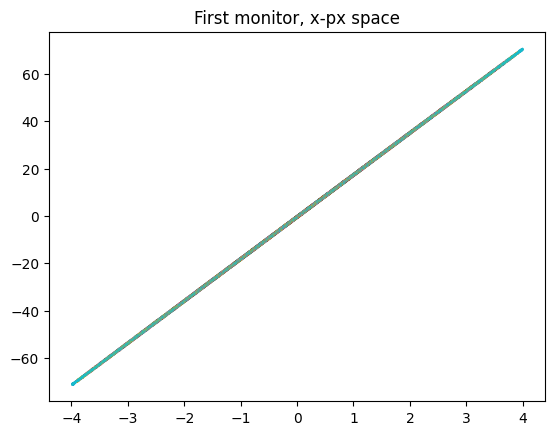

In [11]:
plt.figure()
for i in range(N_part):
    plt.plot(
        monitor.x[i, :] * 1e3,
        monitor.px[i, :] * 1e6,
        # color='black', 
        marker='.', 
        markersize=0.5,
        linestyle='None'
    )
plt.title('First monitor, x-px space')
plt.show()

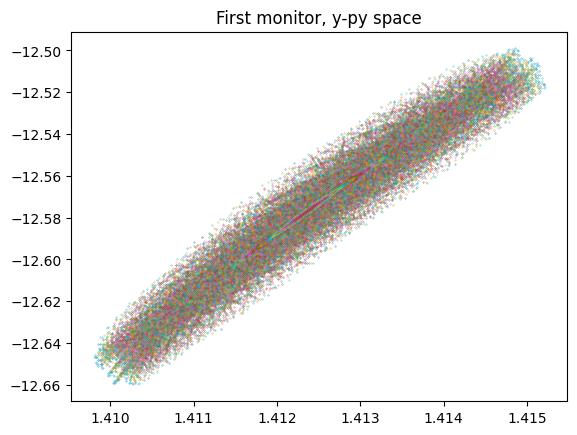

In [12]:
plt.figure()
for i in range(N_part):
    plt.plot(
        monitor.y[i, :] * 1e3,
        monitor.py[i, :] * 1e6,
        # color='black', 
        marker='.', 
        markersize=0.5,
        linestyle='None'
    )
plt.title('First monitor, y-py space')
plt.show()

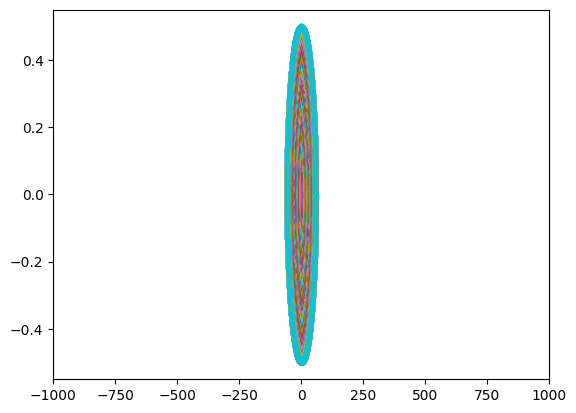

In [13]:
plt.figure()
for i in range(N_part):
    plt.plot(
        monitor.zeta[i, :] * 1e3,
        monitor.delta[i, :] * 1e3,
        # color='black', 
        marker='.'
    )
plt.xlim((-1000, 1000))
plt.show()